In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math

# Load data
df = pd.read_csv("df.csv")

# Convert to datetime
df["CreatedOn"] = pd.to_datetime(df["CreatedOn"])

# Filter district and pest
district = "24 parganas (NORTH DISTRICT)"
pest = "aphid"

filtered_df = df[(df["Dist Name"] == district) & (df["Pest"] == pest)]

# Monthly aggregation
ts = (
    filtered_df
    .set_index("CreatedOn")
    .resample("M")["pest_count"]
    .sum()
)

ts = ts.sort_index()

C:\Users\DELL\AppData\Local\Temp\ipykernel_1592\2325402386.py:11: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df.csv")
C:\Users\DELL\AppData\Local\Temp\ipykernel_1592\2325402386.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["pest_count"]


In [4]:
train_size = int(len(ts) * 0.8)

train = ts[:train_size]
test = ts[train_size:]

print("Training Size:", len(train))
print("Test Size:", len(test))

Training Size: 42
Test Size: 11


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))

train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled = scaler.transform(test.values.reshape(-1,1))

In [8]:
time_step = 12

def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(
    np.concatenate((train_scaled[-time_step:], test_scaled)), 
    time_step
)

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(time_step,1)))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - loss: 0.1309
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1093
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0971
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0930
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0970
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0994
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1005
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0959
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0938
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0913
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0926
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0861
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0912
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0863
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0944
Epoch 16/100
2/2 ━

In [14]:
predicted_scaled = model.predict(X_test)

# Inverse scaling
predicted = scaler.inverse_transform(predicted_scaled)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


In [16]:
residuals = y_test_actual - predicted
std_dev = np.std(residuals)

upper_bound = predicted + 1.96 * std_dev
lower_bound = predicted - 1.96 * std_dev

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, predicted))
mae = mean_absolute_error(y_test_actual, predicted)
r2 = r2_score(y_test_actual, predicted)

print("RMSE:", round(rmse,4))
print("MAE:", round(mae,4))
print("R2 Score:", round(r2,4))

RMSE: 2.6963
MAE: 2.3109
R2 Score: 0.2075


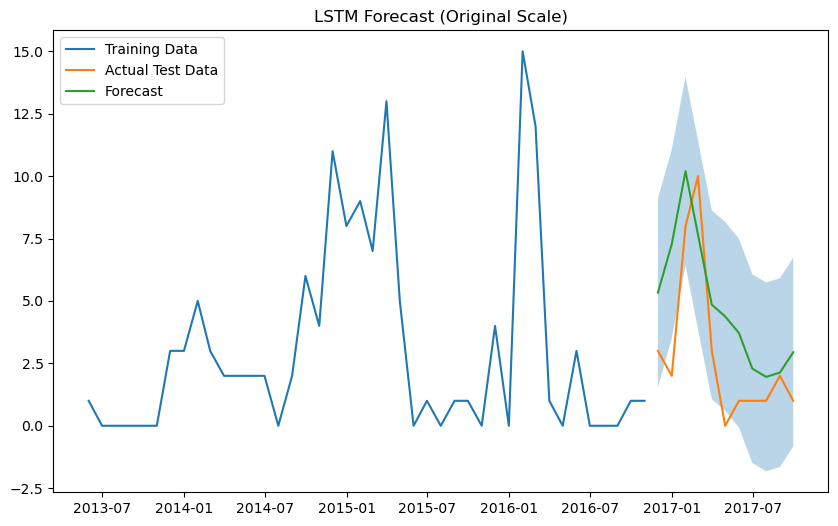

In [20]:
plt.figure(figsize=(10,6))

# Training
plt.plot(train.index, train.values, label="Training Data")

# Actual Test
plt.plot(test.index, test.values, label="Actual Test Data")

# Forecast
plt.plot(test.index, predicted, label="Forecast")

# Confidence Interval
plt.fill_between(
    test.index,
    lower_bound.flatten(),
    upper_bound.flatten(),
    alpha=0.3
)

plt.title("LSTM Forecast (Original Scale)")
plt.legend()
plt.show()